<a href="https://colab.research.google.com/github/yunji1215/ecommerce-analysis-portfolio/blob/main/%ED%8C%A8%EC%85%98%EC%95%84%EC%9D%B4%ED%85%9C_%EA%B0%80%EA%B2%A9_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
conn = sqlite3.connect(':memory:')

Mounted at /content/drive


# 가격 정보에 따른 패션 아이템 유형별 구매 패턴 차이 분석
가격 수준에 따라 아이템 유형별 구매 행동은 어떻게 다르게 나타나는가?

##1. 목적 및 배경 ##
이커머스 환경에서 가격은 소비자의 구매 결정에 있어 가장 기본적인 판단 요소 중 하나이다. 또한, 패션 상품에 대한 구매 결정은 아이템의 특성과 구매 상황에 따라 서로 다른 기준에 의해 이루어질 수 있다. 이 분석에서는 가격 정보를 중심으로 아이템 유형별 구매 행동의 차이를 비교하고, 가격 수준에 따라 거래 빈도와 구매 패턴이 어떻게 달라지는지를 살펴보고자 한다.


## 2. 데이터 구성 ##

In [10]:
customers = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1/customers.csv')
products = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1/products.csv')
stores = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1/stores.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1/transactions.csv')


/tmp/ipython-input-3364282314.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1/customers.csv')


In [12]:
df = transactions.merge(products, on='Product ID', how='left')
df = df.merge(customers, on='Customer ID', how='left')

## 3. 분석 접근 방법 ##

거래 데이터를 아이템 유형 기준으로 분류하고, 가격 분포, 거래 빈도, 반복 구매 여부 등 관찰 가능한 지표를 중심으로 비교 분석하였다.

상품 데이터에 포함된 세부 카테고리를 기반으로, 분석의 일관성을 위해 아이템 유형을 몇 개의 상위 범주로 재분류하였다. 이번 분석에서는 Shoes, Outerwear, Accessories, Bags의 네 가지 유형을 중심으로 분석을 진행하였다.


## 4. 데이터 탐색 및 전처리

In [13]:
df.shape

(6416827, 38)

In [14]:
df.columns

Index(['Invoice ID', 'Line', 'Customer ID', 'Product ID', 'Size', 'Color_x',
       'Unit Price', 'Quantity', 'Date', 'Discount', 'Line Total', 'Store ID',
       'Employee ID', 'Currency', 'Currency Symbol', 'SKU', 'Transaction Type',
       'Payment Method', 'Invoice Total', 'Category', 'Sub Category',
       'Description PT', 'Description DE', 'Description FR', 'Description ES',
       'Description EN', 'Description ZH', 'Color_y', 'Sizes',
       'Production Cost', 'Name', 'Email', 'Telephone', 'City', 'Country',
       'Gender', 'Date Of Birth', 'Job Title'],
      dtype='object')

In [15]:
df.head()

,Invoice ID,Line,Customer ID,Product ID,Size,Color_x,Unit Price,Quantity,Date,Discount,...,Sizes,Production Cost,Name,Email,Telephone,City,Country,Gender,Date Of Birth,Job Title
0,INV-US-001-03558761,1,47162,485,M,NaN,80.5,1,2023-01-01 15:42:00,0.0,...,M|L|XL,12.09,Rachel Herman,rachel.herman@fake_hotmail.com,957.708.4463x102,New York,United States,F,1983-12-25,Risk analyst
1,INV-US-001-03558761,2,47162,2779,G,NaN,31.5,1,2023-01-01 15:42:00,0.4,...,P|M|G,15.14,Rachel Herman,rachel.herman@fake_hotmail.com,957.708.4463x102,New York,United States,F,1983-12-25,Risk analyst
2,INV-US-001-03558761,3,47162,64,M,NEUTRAL,45.5,1,2023-01-01 15:42:00,0.4,...,M|L|XL|XXL,12.02,Rachel Herman,rachel.herman@fake_hotmail.com,957.708.4463x102,New York,United States,F,1983-12-25,Risk analyst
3,INV-US-001-03558762,1,10142,131,M,BLUE,70.0,1,2023-01-01 20:04:00,0.4,...,S|M|L|XL,49.28,Debra Acosta DVM,debra.acosta.dvm@fake_yahoo.com,001-538-724-9305,New York,United States,F,1974-12-12,Pharmacologist
4,INV-US-001-03558762,2,10142,716,L,WHITE,26.0,1,2023-01-01 20:04:00,0.0,...,M|L|XL,8.31,Debra Acosta DVM,debra.acosta.dvm@fake_yahoo.com,001-538-724-9305,New York,United States,F,1974-12-12,Pharmacologist


In [16]:
analysis_cols = [
    'Customer ID',
    'Product ID',
    'Unit Price',
    'Quantity',
    'Line Total',
    'Date',
    'Store ID',
    'Category',
    'Sub Category',
    'Discount',
    'Gender',
    'Country'
]

df_anal = df[analysis_cols].copy()

아이템 유형별 구매 행동을 파악하는 데 직접적으로 필요하지 않은 텍스트 설명, 개인 식별 정보, 내부 관리용 컬럼은 분석 대상에서 제외하였다. 이를 통해 분석에 필요한 핵심 변수만을 중심으로 데이터 구조를 단순화하였다.

In [17]:
df_anal.isna().mean().sort_values(ascending=False)

,0
Customer ID,0.0
Product ID,0.0
Unit Price,0.0
Quantity,0.0
Line Total,0.0
Date,0.0
Store ID,0.0
Category,0.0
Sub Category,0.0
Discount,0.0


In [18]:
df_anal.dtypes

,0
Customer ID,int64
Product ID,int64
Unit Price,float64
Quantity,int64
Line Total,float64
Date,object
Store ID,int64
Category,object
Sub Category,object
Discount,float64


In [19]:
mapping = {
    'Pants and Jeans': 'Bottoms',
    'Skirts and Shorts': 'Bottoms',

    'Coats and Blazers': 'Outerwear',
    'Coats': 'Outerwear',
    'Suits and Blazers': 'Outerwear',

    'Shirts': 'Tops',
    'Shirts and Blouses': 'Tops',
    'T-shirts and Polos': 'Tops',
    'T-shirts and Tops': 'Tops',

    'Sweaters and Sweatshirts': 'Knitwear',
    'Sweaters and Knitwear': 'Knitwear',
    'Sweaters': 'Knitwear',

    'Dresses and Jumpsuits': 'Dresses & Sets',
    'Suits and Sets': 'Dresses & Sets',

    'Accessories': 'Accessories & Others',
    'Lingerie and Pajamas': 'Accessories & Others',
    'Underwear and Pajamas': 'Accessories & Others',
    'Pajamas': 'Accessories & Others'
}

df_anal['item_group'] = df_anal['Sub Category'].map(mapping)

In [20]:
df_anal = df_anal.dropna(subset=['item_group'])

In [21]:
df_anal['item_group'].value_counts(normalize=True)


,proportion
item_group,
Tops,0.239046
Outerwear,0.188390
Bottoms,0.170705
Accessories & Others,0.146754
Knitwear,0.140111
Dresses & Sets,0.114993


### 가격 분포 확인 ###

In [35]:
df_anal.groupby('item_group')['Unit Price'].describe()

,count,mean,std,min,25%,50%,75%,max
item_group,,,,,,,,
Accessories & Others,809425.0,64.052186,83.776849,2.0,18.0,26.5,42.5,358.0
Bottoms,941525.0,140.757123,190.754936,9.0,34.0,57.0,103.5,888.5
Dresses & Sets,634245.0,196.550797,253.935864,18.0,57.4,79.5,125.5,1153.5
Knitwear,772785.0,120.086600,143.368290,13.5,36.0,46.0,69.0,535.0
Outerwear,1039066.0,210.916531,261.812220,18.0,57.0,81.5,259.0,1153.5
Tops,1318459.0,91.612283,116.136481,6.5,25.0,36.0,64.5,535.0


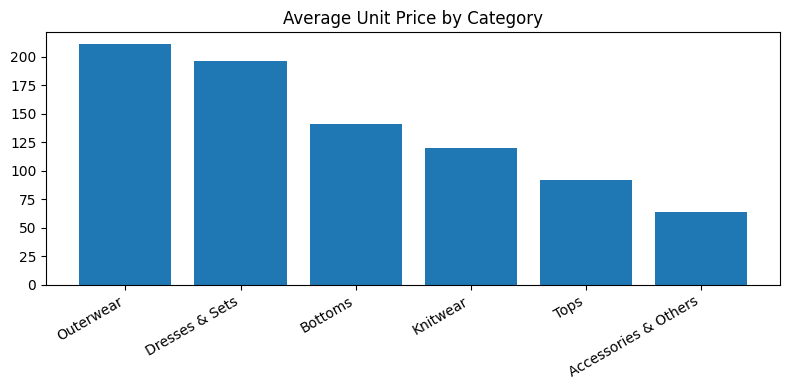

In [34]:
# 가격 분포를 대표하는 평균 가격 bar chart
price_summary = (
    df_anal
    .groupby('item_group')['Unit Price']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,4))
plt.bar(price_summary.index, price_summary.values)
plt.title('Average Unit Price by Category')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

*   Accessories & Others
    - 저가 + 가격이 비교적 고정
    - 가볍게, 부담 없이 구매되는 아이템  
  
    평균: 약 24

    중앙값: 24.5
    
    가격 범위 좁음 (17 ~ 31.5)


*   Tops
    - 중저가 일상 아이템
    - 사람들이 자주 접하고 구매하기 쉬운 가격대

    평균: 약 35

    중앙값: 33

    가격 범위: 25 ~ 42

*   Knitwear
    
    - Tops보다 한 단계 높은 가격
    - 계절성·소재 영향 있는 아이템

    평균: 약 45

    중앙값: 44

    가격 범위: 37 ~ 53

* Bottoms
    
    - 가격대 다양
    - 기본 아이템부터 고가 제품까지 혼재

    평균: 약 55

    중앙값: 49.5
    
    가격 범위 넓음 (34 ~ 74.5)

*   Dresses & Sets
    - 고가 아이템
    - 구매 전에 신중하게 고려하는 경향

    평균: 약 80

    중앙값: 76.5
    
    가격 범위 넓음 (58.5 ~ 96.5)

*   Outerwear
    - 고가 + 선택 폭 넓음
    - 브랜드/소재/디자인 차이가 가격에 크게 반영되는 아이템

    평균: 약 78

    중앙값: 75

    가격 범위 가장 넓음 (56.5 ~ 96)

### 거래 비중 ###

In [30]:
transaction_share = (
    df_anal['item_group']
    .value_counts(normalize=True)
)
transaction_share

,proportion
item_group,
Tops,0.239046
Outerwear,0.188390
Bottoms,0.170705
Accessories & Others,0.146754
Knitwear,0.140111
Dresses & Sets,0.114993


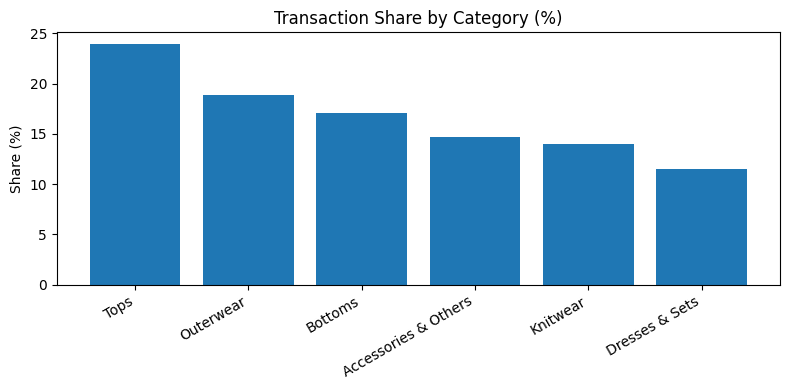

In [31]:
plt.figure(figsize=(8,4))
plt.bar(transaction_share.index, transaction_share.values * 100)
plt.title('Transaction Share by Category (%)')
plt.ylabel('Share (%)')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

* Tops 약 24%
  - 가장 자주 사고파는 아이템
  - 일상적, 접근성 높은 구매

* Outwear 약 20%
  - 자주 사지는 않지만, 존재감 큰 카테고리
  - 한 번 살 때 신중하게 선택
* Bottoms 약 17%
  - 기본 아이템 + 상황에 따라 구매
* Accessories & Others 약 15%
  - 저가·보조적 구매
  - 여러 번 구매될 수는 있지만 핵심 구매는 아님
* Knitwear 약 14%
  - 계절/상황성 있는 구매
* Dresses & Sets 약 10%
  - 가끔, 필요한 경우에만 신중하게 사는 아이템

### 재구매 ###

In [28]:
repeat_purchase = (
    df_anal
    .groupby(['Customer ID','item_group'])
    .size()
    .groupby('item_group')
    .mean()
)
repeat_purchase

,0
item_group,
Accessories & Others,1.549613
Bottoms,1.629954
Dresses & Sets,1.440772
Knitwear,1.537345
Outerwear,1.697110
Tops,1.861347


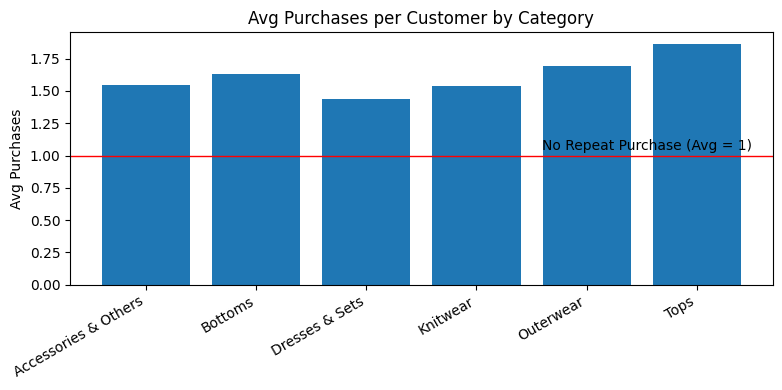

In [38]:
plt.figure(figsize=(8,4))
plt.bar(repeat_purchase.index, repeat_purchase.values)

plt.axhline(y=1, linestyle='-', linewidth=1, color='red')
plt.text(
    x=len(repeat_purchase)-0.5,
    y=1.02,
    s='No Repeat Purchase (Avg = 1)',
    ha='right',
    va='bottom'
)

plt.title('Avg Purchases per Customer by Category')
plt.ylabel('Avg Purchases')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

대부분이 1점 대 초반으로 같은 고객이 같은 아이템 그룹을 여러 번 반복 구매하는 경우는 많지 않다. 또한, 아이템 그룹 간 재구매 횟수에는 일부 차이가 희미하게 존재한다.

In [ ]:
summary = (
    df_anal
    .groupby('item_group')
    .agg(
        avg_price=('Unit Price', 'mean'),
        median_price=('Unit Price', 'median'),
        transaction_share=('item_group', 'count')
    )
)

summary['transaction_share'] = (
    summary['transaction_share'] / summary['transaction_share'].sum()
)

summary.sort_values('avg_price', ascending=False)


,avg_price,median_price,transaction_share
item_group,,,
Dresses & Sets,79.921588,76.5,0.104156
Outerwear,77.706589,75.0,0.198141
Bottoms,55.290614,49.5,0.167216
Knitwear,44.809966,44.0,0.143279
Tops,34.732031,33.0,0.241811
Accessories & Others,24.270323,24.5,0.145397


가격, 거래 비중, 재구매 패턴을 종합적으로 살펴본 결과, 아이템 그룹별로 뚜렷한 구매 맥락의 차이가 나타났다. 가격이 낮은 상의류는 높은 거래 비중을 보이며 일상적이고 접근성이 높은 소비 성격을 띠는 반면, 가격이 높은 드레스 및 아우터류는 거래 비중과 재구매가 모두 낮아 신중한 선택이 이루어지는 아이템으로 해석할 수 있다. 전반적으로 모든 아이템 그룹에서 반복 구매는 활발하지 않았으며, 이는 동일한 구매 기준이 모든 아이템에 적용되기보다는 아이템 특성에 따라 소비자의 의사결정 방식이 달라질 수 있음을 시사한다.

## 결론 ##

가격 수준과 거래 빈도 간의 관계를 살펴본 결과, 일부 아이템 그룹에서는 낮은 가격과 함께 높은 거래 빈도가, 높은 가격과 함께 낮은 거래 빈도가 관찰되었다. 예를 들어 Tops는 낮은 가격대에서 높은 거래 비중을 보인 반면, Dresses & Sets는 높은 가격대에서 낮은 거래 비중을 나타냈다.

다만, Outerwear와 같이 가격 수준이 높음에도 불구하고 일정 수준의 거래 비중을 유지하는 카테고리와, Bottoms처럼 중간 이상의 가격대와 중간 수준의 거래 비중을 함께 보이는 카테고리도 확인되었다. 이는 가격과 거래 빈도의 관계가 모든 아이템에 동일하게 적용되기보다는, 아이템 유형별 특성에 따라 다르게 나타날 수 있음을 시사한다.

이에 따라 각 아이템 그룹 내에서 가격대별 거래량을 추가적으로 분석함으로써, 가격 효과를 보다 정밀하게 검증할 필요가 있다고 판단된다.

또한, 각 아이템 유형을 동일한 성과 지표로 평가하는 것이 적절한지에 대한 재검토가 필요하다고 판단된다. 카테고리별로 어떤 지표를 핵심 판단 기준으로 삼을 것인지에 대한 결정이 선행될 필요가 있다.

## 추가 발견 사항 ##

한편, 가격 중심 분석을 진행하는 과정에서 가격 수준과 무관하게 전반적인 고객 기준 재구매 수준이 낮게 나타난 점이 추가적으로 관찰되었다. 이는 가격 외의 요인이 반복 구매에 영향을 미치고 있을 가능성을 시사하며, 재구매율을 별도의 관점에서 살펴볼 필요성을 제기한다.

예를 들어 Dresses & Sets와 같이 특정 상황이나 이벤트에 따라 구매되는 성격의 아이템은 재구매율이 낮게 나타나는 것이 자연스러운 현상일 수 있다. 반면, Tops, Bottoms, Accessories와 같이 한 고객이 여러 종류를 소장하는 것이 비교적 일반적인 카테고리의 경우에는 재구매를 유도할 수 있는 여지가 존재하는지 검토해볼 필요가 있다.

*  카테고리별로 동일 KPI를 적용하는 것이 적절한가?
*  가격 효과는 어떤 카테고리에서 더 유효한가?
*  재구매율을 전략적 목표로 삼을 카테고리는 어디인가?



## SQL ##

In [ ]:
df_anal.to_sql(
    'analysis_table',
    conn,
    index=False,
    if_exists='replace'
)

157706

### 가격 요약 ###

In [ ]:
query = """
SELECT
  item_group,
  AVG("Unit Price") AS avg_price,
  COUNT(*) * 1.0 / (SELECT COUNT(*) FROM analysis_table) AS transaction_share
FROM analysis_table
GROUP BY item_group
ORDER BY avg_price DESC;
"""

pd.read_sql_query(query, conn)

,item_group,avg_price,transaction_share
0,Dresses & Sets,79.921588,0.104156
1,Outerwear,77.706589,0.198141
2,Bottoms,55.290614,0.167216
3,Knitwear,44.809966,0.143279
4,Tops,34.732031,0.241811
5,Accessories & Others,24.270323,0.145397


### 재구매 분석 ###

In [ ]:
query = """
WITH customer_item_counts AS (
  SELECT
    "Customer ID" AS customer_id,
    item_group,
    COUNT(*) AS purchase_count
  FROM analysis_table
  GROUP BY customer_id, item_group
)
SELECT
  item_group,
  AVG(purchase_count) AS avg_purchases_per_customer
FROM customer_item_counts
GROUP BY item_group;
"""

pd.read_sql_query(query, conn)

,item_group,avg_purchases_per_customer
0,Accessories & Others,1.296506
1,Bottoms,1.339649
2,Dresses & Sets,1.219541
3,Knitwear,1.297651
4,Outerwear,1.379116
5,Tops,1.449945
